# A2C

&emsp;&emsp;A2C为A3C的改进版本，也是一种简化形式。A3C用多个异步并行的工作组进行梯度累积，然后对全局网络进行异步更新，若并行的工作组过多，则网络的参数也会变得巨大，占用较多内存。为了节省内存，A2C仅使用工作组来独立采样，而不再用于累积梯度。当所有工作组的采样总量到达mini-batch大小时，就全部停止采样；全局网络再根据这些样本进行参数更新，具体更新方式与A3C一致。最后再更新工作组参数。

In [7]:
%%writefile A2C.py

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.optim import Adam
from torch.distributions import Normal


class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, act_limit, device):
        super().__init__()
        self.act_limit = torch.as_tensor(act_limit, dtype=torch.float32, device=device)
        self.value_layer1 = nn.Linear(obs_dim, 256)
        self.value_layer2 = nn.Linear(256, 1)
        self.policy_layer1 = nn.Linear(obs_dim, 256)
        self.mu_layer = nn.Linear(256, act_dim)
        self.sigma_layer = nn.Linear(256, act_dim)

    def forward(self, obs):
        value = F.relu6(self.value_layer1(obs))
        value = self.value_layer2(value)
        policy = F.relu6(self.policy_layer1(obs))
        mu = torch.tanh(self.mu_layer(policy)) * self.act_limit
        sigma = F.softplus(self.sigma_layer(policy))
        return value, mu, sigma

    def select_action(self, obs):
        _, mu, sigma = self.forward(obs)
        pi = Normal(mu, sigma)
        return pi.sample().cpu().numpy()

    def loss_func(self, states, actions, v_t, beta):
        values, mu, sigma = self.forward(states)
        td = v_t - values
        value_loss = torch.squeeze(td ** 2)

        pi = Normal(mu, sigma)
        log_prob = pi.log_prob(actions).sum(axis=-1)
        entropy = pi.entropy().sum(axis=-1)
        policy_loss = -(log_prob * torch.squeeze(td.detach()) + beta * entropy)
        return (value_loss + policy_loss).mean()


class Worker(mp.Process):
    def __init__(self, id, device, env_name, global_network_lock,  # obs_dim, act_dim, act_limit,
                 global_network, global_optimizer,
                 gamma, beta, global_T, global_T_MAX, t_MAX,
                 global_episode, global_return_display, global_return_record, global_return_display_record):
        super().__init__()
        self.id = id
        self.device = device
        self.env = gym.make(env_name)
        self.global_network_lock = global_network_lock
        self.global_network = global_network
        self.global_optimizer = global_optimizer
        self.gamma, self.beta = gamma, beta
        self.global_T, self.global_T_MAX, self.t_MAX = global_T, global_T_MAX, t_MAX
        self.global_episode = global_episode
        self.global_return_display = global_return_display
        self.global_return_record = global_return_record
        self.global_return_display_record = global_return_display_record

    def update_global(self, states, actions, rewards, next_states, done, gamma, beta, optimizer):
        if done:
            R = 0
        else:
            R, mu, sigma = self.global_network.forward(next_states[-1])
        length = rewards.size()[0]
        v_t = torch.zeros([length, 1], dtype=torch.float32, device=self.device)
        for i in range(length, 0, -1):
            R = rewards[i - 1] + gamma * R
            v_t[i - 1] = R
        loss = self.global_network.loss_func(states, actions, v_t, beta)
        with self.global_network_lock.get_lock():
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    def run(self):
        t = 0
        state, done = self.env.reset(), False
        episode_return = 0
        while self.global_T.value <= self.global_T_MAX:
            t_start = t
            buffer_states, buffer_actions, buffer_rewards, buffer_next_states = [], [], [], []
            while not done and t - t_start != self.t_MAX:
                action = self.global_network.select_action(torch.as_tensor(state, dtype=torch.float32, device=self.device))
                next_state, reward, done, _ = self.env.step(action)
                episode_return += reward
                buffer_states.append(state)
                buffer_actions.append(action)
                buffer_next_states.append(next_state)
                buffer_rewards.append(reward / 10)
                t += 1
                with self.global_T.get_lock():
                    self.global_T.value += 1
                state = next_state
            self.update_global(
                torch.as_tensor(buffer_states, dtype=torch.float32, device=self.device),
                torch.as_tensor(buffer_actions, dtype=torch.float32, device=self.device),
                torch.as_tensor(buffer_rewards, dtype=torch.float32, device=self.device),
                torch.as_tensor(buffer_next_states, dtype=torch.float32, device=self.device),
                done, self.gamma, self.beta, self.global_optimizer
            )
            if done:
                with self.global_episode.get_lock():
                    self.global_episode.value += 1
                    self.global_return_record.append(episode_return)

                    if self.global_episode.value == 1:
                        self.global_return_display.value = episode_return
                    else:
                        self.global_return_display.value *= 0.99
                        self.global_return_display.value += 0.01 * episode_return
                        self.global_return_display_record.append(self.global_return_display.value)
                        if self.global_episode.value % 10 == 0:
                            print('Process: ', self.id, '\tepisode: ', self.global_episode.value, '\tepisode_return: ', self.global_return_display.value)

                episode_return = 0
                state, done = self.env.reset(), False


if __name__ == "__main__":
    
    mp.set_start_method('spawn')
    
    device = 'cuda:1'
    env_name = 'Pendulum-v0'
    num_processes = 8
    gamma = 0.9
    beta = 0.01
    lr = 1e-4
    T_MAX = 1000000
    t_MAX = 5

    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    act_limit = env.action_space.high
    global_network_lock = mp.Value('i', 0)
    global_network = ActorCritic(obs_dim, act_dim, act_limit, device).to(device)
    global_network.share_memory()
    optimizer = Adam(global_network.parameters(), lr=lr)
    global_episode = mp.Value('i', 0)
    global_T = mp.Value('i', 0)
    global_return_display = mp.Value('d', 0)
    global_return_record = mp.Manager().list()
    global_return_display_record = mp.Manager().list()

    workers = [Worker(i, device, env_name, global_network_lock,  # obs_dim, act_dim, act_limit, \
                      global_network, optimizer, gamma, beta,
                      global_T, T_MAX, t_MAX, global_episode,
                      global_return_display, global_return_record, global_return_display_record) \
               for i in range(num_processes)]
    [worker.start() for worker in workers]
    [worker.join() for worker in workers]

    torch.save(global_network, 'a2c_Pendulum-v0_model.pth')

    import matplotlib.pyplot as plt
    save_name = 'a2c_gamma=' + str(gamma) + '_beta=' + str(beta) + '_' + env_name
    save_data = np.array(global_return_record)
    plt.plot(np.array(global_return_display_record))
    np.save(save_name + '.npy', save_data)
    plt.ylabel('return')
    plt.xlabel('episode')
    plt.savefig(save_name + '.png')

Overwriting A2C.py


In [9]:
! python ./A2C.py

Process:  5 	episode:  10 	episode_return:  -1448.2792138810332
Process:  7 	episode:  20 	episode_return:  -1442.8477726367014
Process:  2 	episode:  30 	episode_return:  -1453.0968135487694
Process:  4 	episode:  40 	episode_return:  -1479.7137683003155
Process:  5 	episode:  50 	episode_return:  -1500.4274618269465
Process:  7 	episode:  60 	episode_return:  -1517.0331060397266
Process:  2 	episode:  70 	episode_return:  -1537.1683381237046
Process:  4 	episode:  80 	episode_return:  -1555.4150097063953
Process:  5 	episode:  90 	episode_return:  -1568.7772384386608
Process:  7 	episode:  100 	episode_return:  -1580.5915933176216
Process:  2 	episode:  110 	episode_return:  -1585.3569944100695
Process:  4 	episode:  120 	episode_return:  -1591.21102506725
Process:  5 	episode:  130 	episode_return:  -1594.8159666561571
Process:  7 	episode:  140 	episode_return:  -1595.4378239167027
Process:  2 	episode:  150 	episode_return:  -1595.9816799639852
Process:  3 	episode:  160 	episode_

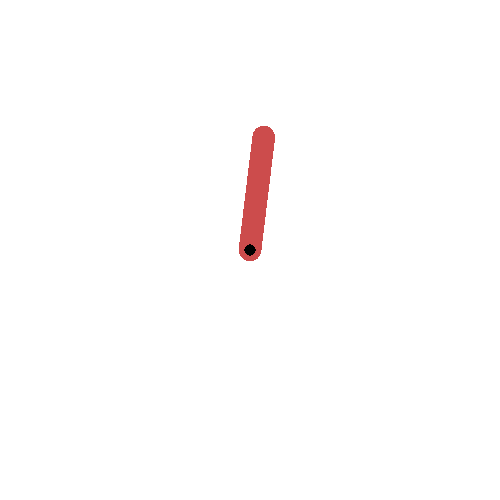

In [ ]:
# 显示训练好的模型
# 导入相应的模块
import gym
import pybullet_envs
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.optim import Adam
from torch.distributions import Normal

# ActorCritic网络定义
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, act_limit, device):
        super().__init__()
        self.act_limit = torch.as_tensor(act_limit, dtype=torch.float32, device=device)
        self.value_layer1 = nn.Linear(obs_dim, 256)
        self.value_layer2 = nn.Linear(256, 1)
        
        self.policy_layer1 = nn.Linear(obs_dim, 256)
        self.mu_layer = nn.Linear(256, act_dim)
        self.sigma_layer = nn.Linear(256, act_dim)

    def forward(self, obs):
        value = F.relu6(self.value_layer1(obs))
        value = self.value_layer2(value)
        policy = F.relu6(self.policy_layer1(obs))
        mu = torch.tanh(self.mu_layer(policy)) * self.act_limit
        sigma = F.softplus(self.sigma_layer(policy))
        return value, mu, sigma

    def select_action(self, obs):
        _, mu, sigma = self.forward(obs)
        pi = Normal(mu, sigma)
        return pi.sample().cpu().numpy()

    def loss_func(self, states, actions, v_t, beta):
        values, mu, sigma = self.forward(states)
        td = v_t - values
        value_loss = torch.squeeze(td ** 2)

        pi = Normal(mu, sigma)
        log_prob = pi.log_prob(actions).sum(axis=-1)
        entropy = pi.entropy().sum(axis=-1)
        policy_loss = -(log_prob * torch.squeeze(td.detach()) + beta * entropy)
        return (value_loss + policy_loss).mean()

# 这段代码用来在jupyter中代替env.render()
from PIL import Image
from IPython import display

def render(env):   
    display.display(Image.fromarray(env.render(mode='rgb_array')))
    display.clear_output(wait=True)  

a2c_model = torch.load('a2c_Pendulum-v0_model.pth').to('cuda:1')
env = gym.make('Pendulum-v0')
state = env.reset()
while True:
    render(env)
    _, mu, sigma = a2c_model.forward(torch.as_tensor(state, dtype=torch.float32, device='cuda:1'))
    action = Normal(mu, sigma).sample().cpu().numpy()
    state, reward, done, _ = env.step(action)    